# Colab setup

Preparazione dell'ambiente di esecuzione del colab notebook. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Colab_yelp/Yelp-Data-Analysis

In [ ]:
! git pull

In [ ]:
! pip install -q -U "tensorflow-text==2.8.*"
! pip install -q tf-models-official==2.7.0
! pip install keras-tuner

# TASK 3

Ogni recensione lasciata sul sito Yelp può ricevere feedback da altri utenti, che possono contrassegnarla come *funny*, *cool* e/o *useful*.

L'obbiettivo del presente studio è quello di valutare diverse tecniche di machine learning fini alla predizione dell'utilità di una review.
Il problema è stato trattato in due modi differenti:
- Problema di regressione: predizione numero di feedback *useful*
- Problema di classificazione: predizione livello (classe) di utilità:
    - 'not useful' (voti 'useful' <=5 )
    - 'moderetely useful' (5 < voti 'moderetely useful' <=25 )
    - 'extremely useful' (25 < voti 'extremely useful')

In [1]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from official.nlp import optimization

# from libraries import data_handler
from libraries import data_handler
from libraries.dataset import Dataset

import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
import keras_tuner as kt
import pandas as pd

import libraries.preprocessing_utils as prep_utils
import libraries.models_builders as models_builders
import libraries.filenames_generator as filenames  
import constants as const

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aless_vzq3wiu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aless_vzq3wiu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aless_vzq3wiu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


## Data retrieving

In [ ]:
data = data_handler.load_dataset('review')

Loading review dataset...
		0 chunks loaded
		50 chunks loaded
		100 chunks loaded
		150 chunks loaded
		200 chunks loaded
		250 chunks loaded
		300 chunks loaded
		350 chunks loaded
		400 chunks loaded
		450 chunks loaded
		500 chunks loaded
		550 chunks loaded
		600 chunks loaded
		650 chunks loaded
		700 chunks loaded
		750 chunks loaded
		800 chunks loaded
		850 chunks loaded
Loaded dataset with 8635403 rows and 11 columns and saved in ./data/pickled/review.pkl


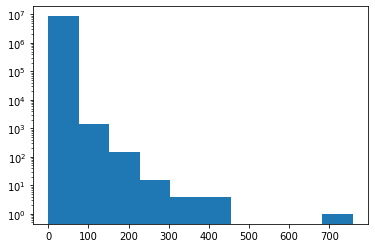

In [4]:
plt.hist(data['useful'], log=True)
plt.show()

In [5]:
data['usefulness'].value_counts()

not useful           8248608
moderately useful     369176
extremely useful       17619
Name: usefulness, dtype: int64

In [3]:
review_data = Dataset('review', 'usefulness')

# 30_000 elements for each class
review_data.split(['text', 'useful'], 'usefulness', val_size=0.1, test_size=0.1, n_samples=30_000)

Reading ./data/balanced_review_usefulness_train.csv...
File loaded in 0.0256 minutes
Reading ./data/balanced_review_usefulness_val.csv...
File loaded in 0.0028 minutes
Reading ./data/balanced_review_usefulness_test.csv...
File loaded in 0.0029 minutes


## Data preprocessing comune

In [ ]:
prep_train_data = prep_utils.preprocess_texts(review_data.train_data[0]['text'], path= filenames.picked_cleaned_sentences(
        "train", "task3"))

prep_test_data = prep_utils.preprocess_texts(review_data.test_data[0]['text'], path= filenames.picked_cleaned_sentences(
        "test", "task3"))

prep_val_data = prep_utils.preprocess_texts(review_data.val_data[0]['text'], path= filenames.picked_cleaned_sentences(
        "val", "task3"))


## Training dei modelli
Per i modelli predittivi basati unicamente sul testo come input, sono state testate due tecniche di deep learning:
- **LSTM**
- **BERT**

Entrambe le architetture sono state utilizzate sia per la risoluzione del problema visto come  di classificazione che di regressione.

<!-- Riguardo i modelli utilizzati invece con un insieme più ampio di features, sono stati scelti i seguenti modelli:
- random forest
- svm -->

### Classificatore LSTM

Sono state testate diverse architetture delle RNN di tipo LSTM, al fine di trovare la combinazione di iperparametri che rendono le migliori performance.

Riguardo il preprocessing aggiuntivo sui dati, è stato utilizzato un tokenizer specifico, il quale restituisce per ogni review un vettore contenente gli indici delle parole nel dizionario (estratto dalla collezione di reviews).

Tali indici sono fondamentali per il recupero delle word embedding corrispondenti alle parole delle reviews, azione che avviene nel layer di tipo Embedding impostato come primo layer della rete neurale.


In [4]:
tokenizer = prep_utils.get_tokenizer(review_data.train_data[0]['text'])

train_tokens = prep_utils.get_set_tokens(
    review_data.train_data[0]['text'], tokenizer, set='train', task='task3')

test_tokens = prep_utils.get_set_tokens(
    review_data.test_data[0]['text'], tokenizer, set='test', task='task3')

val_tokens = prep_utils.get_set_tokens(
    review_data.val_data[0]['text'], tokenizer, set='val', task='task3')

Esistono diverse metodologie per la definizione dei word vectors, dal training di reti come Word2Vec all'utilizzo di mapping già pre-trained

Nel caso di questo studio è stato scelto di creare un'embedding matrix a partire da un mapping già esistente, nello specifico quello messo a disposizione da Glove e addestrato su una grande mole di dati testuali estratti da twitter.
Sulla base di questo mapping, sono stati estratti, ed inseriti in una matrice, i vettori delle parole presenti nel dizionario e, se non presenti, queste sono stati rappresentati come 0-vector.

In [5]:
e_matrix = prep_utils.get_embedding_matrix(const.word_embedding_filepath, 'task3',
                                            tokenizer, len(tokenizer.index_word)+1)

word_vector_dim = 100

vocab_size = len(tokenizer.word_index)+1
max_length = len(max(train_tokens, key=len))

embedding_layer = Embedding(vocab_size, word_vector_dim,
                            embeddings_initializer=Constant(e_matrix), trainable=False)

Loading pickled embedding matrix from ./data/embedding/task3_embedding_matrix.npy...
...embedding matrix loaded


Inizio fase di tuning degli iperparametri, la ricerca è divisa in due trial diverse, caratterizzate principalmente da due batch size differenti. 

Gli iperparametri testati sono:
- numero di units (dimensione del vettore delle celle e hidden states)
- percentuale di dropout
- learning rate

Il training è gestito utilizzando la tecnica dell'early stopping, gestita dalla seguente callback, che termina il training dopo 15 epoche prive di miglioramenti.

In [6]:
# define custom callbacks
stop_early_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)

### Primo hypeperameters tuning trial

In [8]:
project_name = "task3_lstm_adam_16"

builder = models_builders.get_rnn_builder(
    drop=[0.2, 0.5],
    units=[50, 100, 200],
    lrate=[0.01, 0.001],
    optimizer=keras.optimizers.Adam,
    embedding_layer=embedding_layer,
    output_shape=3, # out classes
    activation='softmax',
    loss='categorical_crossentropy')

tuner = kt.RandomSearch(
    builder,
    objective = 'val_accuracy',
    max_trials = 10,
    directory = const.tuner_path, project_name = project_name
)

tuner.search_space_summary()

Search space summary
Default search space size: 3
dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.5], 'ordered': True}
units (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 200], 'ordered': True}
lr (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


In [9]:
tuner.search(train_tokens,
             pd.get_dummies(review_data.train_data[1]),
             batch_size=16, epochs=1000,
             validation_data=(val_tokens, pd.get_dummies(review_data.val_data[1])),
             callbacks=[
                 stop_early_cb,
                 tf.keras.callbacks.TensorBoard(const.logs_path + project_name, update_freq='epoch')],
             verbose=1)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.2               |?                 |dropout
200               |?                 |units
0.001             |?                 |lr

Epoch 1/1000
3881/3881 [==============================] - 445s 112ms/step - loss: 0.9221 - accuracy: 0.5596 - val_loss: 0.8982 - val_accuracy: 0.5749
Epoch 2/1000
 929/3881 [======>.......................] - ETA: 5:08 - loss: 0.8859 - accuracy: 0.5807

KeyboardInterrupt: 